In [2]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

# Load the TensorBoard notebook extension
%load_ext tensorboard

%aimport models.AEFIT2
%aimport models.AEFIT3

%aimport models.base
!pip install livelossplot --user


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
qsh = Htls.QSH_Dataset()
import os
file = ipysh.abs_builddir+'/te_db_r15.npy'
if os.path.isfile(file):
    qsh.load(file)
else:
    qsh.load(ipysh.abs_builddir+'/te_db_1.npy')    
    qsh.rebalance_prel(15)
    qsh.save(ipysh.abs_builddir+'/te_db_r15.npy')
    
qsh.shuffle()
# qsh.filter_number_set(15)
qsh.clean_up_poorcurves(5)
qsh.dim = 15
qsh.set_null(np.nan)
qsh.set_normal_positive()
qsh.unbias_mean(0.5, 'te')
qsh.set_normal_positive()

print("QSH rebalanced 15 points size: ", len(qsh))

qsh.set_null(np.nan)
qsh.clip_values(0.1,0.6)
qsh.set_normal_positive()

QSH rebalanced 15 points size:  61519


## VAE AEFIT3 reconstruction - beta

This is the Analytical way to compute KL term ... beta is applied to KL

In [94]:
vae = models.AEFIT3.AEFIT3(latent_dim=2, feature_dim=30, dprate=0.4, scale=4, beta=0.)

AEFIT3 pz ready:


In [95]:
p = Hplt.LSPlotBokeh()
p.set_model(vae)
p.set_data(qsh, counts=3000)
p.plot_notebook(notebook_url='http://172.17.0.2:8888')

Loading BokehJS ...

In [21]:
models.base.train(vae, qsh, batch=200, epoch=1, loss_factor=1e-3)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
307/307 [==============================] - 32s 103ms/step - loss: 18.4326 - accuracy: 0.9173 - sce: 18.5743 - akl: 3.4448 - kld: 3.9404 - v_mea: 0.7436 - v_std: 0.3897


In [96]:
thread = models.base.train_thread(vae, qsh, batch=200, epoch=5, loss_factor=1e-3)

In [97]:
thread.start()


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/5
307/307 [==============================] - 36s 117ms/step - loss: 18.4664 - accuracy: 0.9257 - sce: 18.6766 - akl: 2.0685 - kld: 2.8171 - v_mea: 0.1936 - v_std: 0.5028

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009000000427477062.
Epoch 2/5
307/307 [==============================] - 36s 117ms/step - loss: 18.3802 - accuracy: 0.9901 - sce: 18.3875 - akl: 6.2621 - kld: 7.0322 - v_mea: 0.2746 - v_std: 0.0560

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000729000034625642.
Epoch 3/5
307/307 [==============================] - 35s 114ms/step - loss: 18.3635 - accuracy: 0.9909 - sce: 18.3695 - akl: 9.0120 - kld: 9.6770 - v_mea: 0.3463 - v_std: 0.0175

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0005314410154824146.
Epoch 4/5
307/307 [==============================] - 36s 116ms/step - loss: 18.3584 - accuracy: 0.9913 - sce: 18.3627 - akl: 10

In [ ]:
thread._stop.set()


In [ ]:
# vae.save('step6.5_r15_v3')

In [ ]:
vae.load('step6.6_r15_v3')

In [154]:
qsh_pos = 0

22


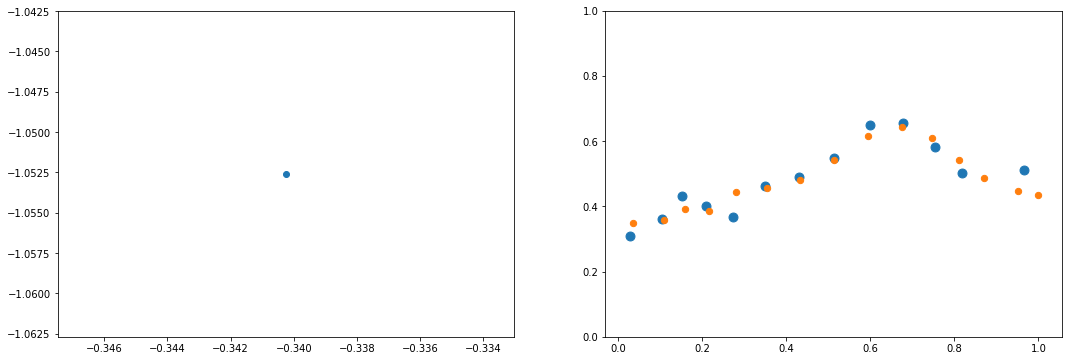

In [177]:
fig = plt.figure('test_curve',figsize=(18, 6))
plt.clf()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)    
# ax1.set_xlim(-2.,2.)
ax2.set_ylim(0.,1.)


for xy in qsh.ds_array.skip(qsh_pos).take(1):    
    xy,_ = xy
    x,y = tf.split(xy,2)
    ax2.scatter(x,y,s=80)
    m,v  = vae.encode([xy], training=False)
    gpt = m[0].numpy()
    ax1.scatter(gpt[0],gpt[1])
    
    XY = vae.decode(m,apply_sigmoid=True, training=False)
    X,Y = tf.split(XY[0], 2)
    X,Y = (X.numpy(), Y.numpy())
    ax2.scatter(X,Y,s=40)

print(qsh_pos)    
qsh_pos += 1
    